In [2]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.models import load_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import *
from keras.layers import *
from keras.callbacks import *
import seaborn as sns

######################### import data ########################
with open('SemEval2017-task4-dev.subtask-A.english.INPUT.txt') as f:
    lines = f.readlines()

data=[item.split("\t") for item in lines]
# print(data)
X=[]
y=[]
for item in data:
    # print(item)
    try:
        X.append(item[2])
        y.append(item[1])
    except:
        pass

Y=list()
for label in y:
    if label == 'neutral':
        Y.append([0, 1, 0])
    elif label == 'negative':
        Y.append([1, 0, 0])
    elif label == 'positive':
        Y.append([0, 0, 1])

######################## cleaning data and removing punctuations ################
AM=list()
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
for text in X:
    for ele in text:
        if ele in punc:
            text = text.replace(ele, "")
    AM.append(text)

X=AM

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

########################## create indexes of the embedding layer #####################

MAX_SEQUENCE_LENGTH=40

tokenizer = Tokenizer()

max_length = len(max(X, key=len))
max_length = min(max_length, MAX_SEQUENCE_LENGTH)

# Create vocabularies and their indexes with training texts.
tokenizer.fit_on_texts(X)

####################### reforming traing and testing data to indexes vector ###################
train_indexes_vec = tokenizer.texts_to_sequences(X_train)
train_indexes_vec = pad_sequences(train_indexes_vec, maxlen=max_length, truncating='post', padding='post')

test_indexes_vec = tokenizer.texts_to_sequences(X_test)
test_indexes_vec = pad_sequences(test_indexes_vec, maxlen=max_length, truncating='post', padding='post')

####################### import glove as pretrained model ####################
embeddings_index = dict()
f = open('glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        pass

f.close()

##################### restricting embedding layer matrix to needed vocabulary ##################
size_of_vocabulary=len(tokenizer.word_index)+1

embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#################### create deep learning model based on the keras framework ##########################
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
# model.add(Embedding(size_of_vocabulary,  # number of unique tokens
#                           300,  # number of features
#                           embeddings_initializer=Constant(embedding_matrix),  # initialize
#                           input_length=MAX_SEQUENCE_LENGTH,
#                           trainable=True))

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.4))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dense(3,activation='softmax'))

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["acc"])

#Adding callbacks
mc=ModelCheckpoint('best_model_lstm.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)

#Print summary of model
print(model.summary())

########################## Training the model with training data #####################
print('Starting....')
history = model.fit(np.array(train_indexes_vec),np.array(y_train),batch_size=32,epochs=20,validation_data=[np.array(test_indexes_vec),np.array(y_test)],verbose=2,shuffle=True,callbacks=[mc])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           11565600  
                                                                 
 lstm (LSTM)                 (None, 40, 128)           219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                        

In [4]:
########################## loading best model #########################
loaded_model = load_model("best_model_lstm.h5")

########################## Evaluation testing data ########################
score = loaded_model.evaluate(np.array(test_indexes_vec), np.array(y_test), verbose=2)
print('test_accuracy: ',score[1],'test_loss: ', score[0])



129/129 - 1s - loss: 0.6980 - acc: 0.6901 - 1s/epoch - 10ms/step
test_accuracy:  0.6900896430015564 test_loss:  0.6980050206184387


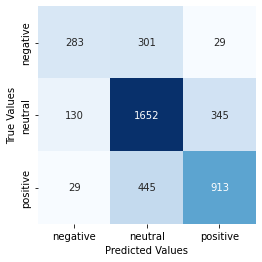

In [5]:
########################## Plot confusion matrix ############################
y_pred = loaded_model.predict(np.array(test_indexes_vec), verbose=0) # predict the data to compare with the ground truth

Y_pred = np.argmax(y_pred, 1)
Y_test = np.argmax(np.array(y_test), 1)

mat = confusion_matrix(Y_pred, Y_test)
labels=['negative','neutral','positive']
sns.heatmap(mat.T, square=True,annot=True ,cbar=False, cmap=plt.cm.Blues, fmt='.0f',xticklabels=labels,yticklabels=labels)

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()


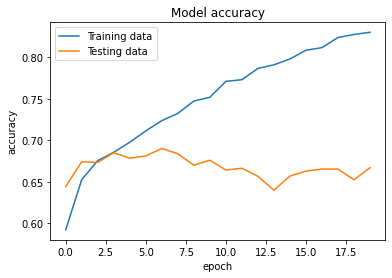

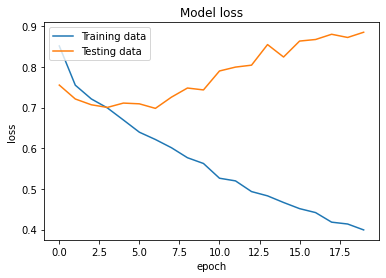

In [6]:
########################### Plot result ###############################
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training data', 'Testing data'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training data', 'Testing data'], loc='upper left')
plt.show()